# Riiid---Answer-Correctness-Prediction
Predicting Student Performance on future interactions with an AI tutor
# Project Overview

## Issues in Education
First, I’d like to talk about some issues in education today. According to data gathered by the UNESCO Institute, in 2018, 260 million children weren’t attending school. Of the children that we’re attending school, more than half of young students around the globe did not meet minimum reading and math standards. This is in part due to the fact that many students don’t have access to personalized learning.

Education was already in a tough place before COVID forced many schools to shutdown and switch to remote learning. I created this map in Tableau with data from UNESCO Institute.

<b>School Closure Due to COVID-19 May 2020</b>
![COVID MAP](../../reports/figures/COVID_map.png)

## Education with Artificial Intelligence
 Artificial Intelligent solutions can change the current education system in terms of attendance, engagement, and individualized attention. It could potentially provide equal opportunity in education to anyone with an internet connection. With these goals in mind, RIIID Labs developed AI tutors.

Aiming to rethink traditional ways of learning, RIID Labs launched EdNet this year, the world’s largest open database for AI education. The database, which is hosted on Kaggle.com, contains data on more than 100 million student interactions across almost 400 thousand students for over 13,000 questions.

## Student Performance Predictions on AI tutor
I will be predicting whether the student will answer incorrect, or correct for future questions. The purpose of these predictions is to help evaluate and guide the success of the AI tutors. The AI tutor can become more individualized to a student’s needs if they know the predicted performance. For example, it could provide more questions and lectures on topics it sees the student is predicted to be weak in.

# Import Libraries

In [99]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from dask.distributed import Client, LocalCluster
import joblib

In [100]:
cluster = LocalCluster()
client = Client(cluster) # start a local Dask client

In [101]:
cluster

# Data

#### Import Data

In [102]:
# Connect to the PostgreSQL database riiid_education we created previously
# Note: Run create SQL database notebook if database not created
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [103]:
#create a list of the table names
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = []
for table in cursor.fetchall():
    tables.append(table[0])
tables

['train', 'questions', 'lectures', 'example_test']

In [104]:
# Read in Data from Database
train = pd.read_csv('../../data/train.csv')
# train = pd.read_sql("""SELECT * 
# FROM train;""", conn)
questions = pd.read_sql("SELECT * FROM questions;", conn)
lectures = pd.read_sql("SELECT * FROM lectures;", conn)
conn.close()

### Explore Data

In [105]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


<b>Description of Features in Train</b>

`row_id` - ID for the row.

`timestamp` - the time between this user interaction and the first event from that user.

`user_id` - ID for the user.

`content_id` - ID for the user interaction

`content_type_id` - 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture. Every row with 1 has an answered_correctly value of not answered(-1). Filtering out all rows with content id 1 filters out all the unanswered questions. This is the culprit of our 100% predictions on unanswered.

`task_container_id` - ID for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

`user_answer` - the user's answer to the question, if any. Read -1 as null, for lectures.

`answered_correctly` - if the user responded correctly. Read -1 as null, for lectures.

`prior_question_elapsed_time` - How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

`prior_question_had_explanation` - Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [106]:
train.shape
# 101,230,332 rows

(101230332, 10)

In [107]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in train.columns:
    print(f"{column}: {train[column].nunique()}")

Count of unique values in each column
row_id: 101230332
timestamp: 72821015
user_id: 393656
content_id: 13782
content_type_id: 2
task_container_id: 10000
user_answer: 5
answered_correctly: 3
prior_question_elapsed_time: 3258
prior_question_had_explanation: 2


In [108]:
# Drop all rows with answered_correctly is blank (-1) since these are lectures, not questions
train = train[train.content_type_id != 1]

Categorical Features: `content_type_id`, `user_answer`, `answered_correctly`, `prior_question_had_explanation`

In [109]:
questions.head()

,question,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38 ...
1,1,1,1,1,131 36 81 ...
2,2,2,0,1,131 101 162 92 ...
3,3,3,0,1,131 149 162 29 ...
4,4,4,3,1,131 5 162 38 ...


<b>Description of Features in Questions</b>

`question` - foreign key for the train/test content_id column, when the content type is question (0).

`bundle_id` - code for which questions are served together.

`correct_answer` - the answer to the question. Can be compared with the train user_answer column to check if the user was right.

`part` - top level category code for the question.

`tags` - one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [110]:
questions.shape

(13523, 5)

In [111]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in questions.columns:
    print(f"{column}: {questions[column].nunique()}")

Count of unique values in each column
question: 13523
bundle_id: 9765
correct_answer: 4
part: 7
tags: 1519


Categorical Features: `correct_answer`, `part`

Note - Should only need bundle_id and part column. If i use tag column, will need to split the tags to a feature each

In [112]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


<b>Description of Features in Questions</b>

`lecture_id` - foreign key for the train/test content_id column, when the content type is lecture (1).

`part` - top level category code for the lecture.

`tag` - one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

`type_of` - brief description of the core purpose of the lecture

In [113]:
# Find number of unique values in each column
print("Count of unique values in each column")
for column in lectures.columns:
    print(f"{column}: {lectures[column].nunique()}")

Count of unique values in each column
lecture_id: 418
tag: 151
part: 7
type_of: 4


#### Merge train and questions tables

In [114]:
df = train.merge(questions, left_on='content_id', right_on='question', how='left')

In [115]:
# Drop the columns we don't need
# question is already there as content id
# user_answer doesn't make sense to have - we can't know that in advance
# There are only 2 unique content_type_ids and we dropped one type, no point having a column of zeros
# tags has to do with the lecture tags, adressing would be way too calculation heavy for my computer to handle.
df.drop(['tags', 'question', 'user_answer', 'content_type_id'], axis=1, inplace=True)

#### Feature Engineering

In [116]:
# Engineer Feature for how many questions this user has answered prior
df["user_question_count"] = df.groupby("user_id").cumcount() + 1

In [117]:
# Engineer Feature for average time per questions per user for prior questions
cumsum = df.groupby("user_id")["prior_question_elapsed_time"].cumsum()
count = df.groupby("user_id").cumcount() + 1
df["avg_time_per_question"] = round(cumsum/count, 0)

In [118]:
df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')

In [119]:
# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

### Data Visualization

In [22]:
# # Class Distribution for ppt
# sns.set(context = 'notebook',  style = 'whitegrid')
# fig, ax = plt.subplots(figsize = (6,6)) 
# ax = sns.countplot(y, palette = ['#d77ead', '#645ca7'])
# ax.axes.set_title("Class Distribution",fontsize=28, color='white')
# ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
# ax.set_xticklabels(['Incorrect', "Correct"], fontsize=15, color='white')
# ax.set_yticklabels(['0', '10,000,000', '20,000,000', '30,000,000', '40,000,000', '50,000,000', '60,000,000'],
# fontsize=15, color='white')
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('White')
# # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.savefig('../../reports/figures/class_imbalance_ppt.png', bbox_inches='tight', transparent=True);

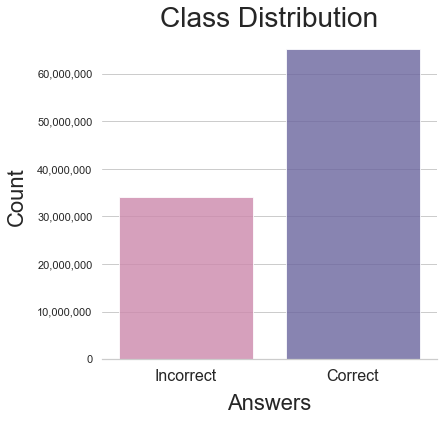

In [23]:
# Class Distribution
sns.set(context = 'notebook', style='whitegrid')
fig, ax = plt.subplots(figsize = (6,6)) 
ax = sns.countplot(y, palette = ['#d77ead', '#645ca7'], alpha=.8)
ax.axes.set_title("Class Distribution",fontsize=28)
ax.set_xlabel("Answers",fontsize=22, labelpad=10)
ax.set_ylabel("Count",fontsize=22, labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=16)
# ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/class_imbalance_ppt.png', bbox_inches='tight', transparent=True);

In [24]:
# # PPT Viz for Questions Answered per Topic
# plt.figure(figsize = (10, 5))
# ax = sns.countplot(data=df, x='part', hue='answered_correctly', palette=['#d77ead', '#645ca7'])
# ax.set(xlabel = '', ylabel = '')
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
# ax.axes.set_title("Questions Answered per Topic", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Topic",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
# ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '5,000,000', '10,000,000', '15,000,000', '20,000,000', '25,000,000'], fontsize=15, color='white')
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.savefig('../../reports/figures/parts_ppt.png', bbox_inches='tight', transparent=True);

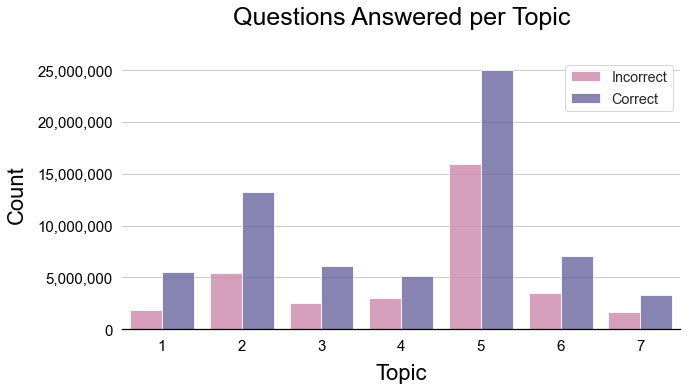

In [124]:
# Viz for Questions Answered per Topic
sns.set(context = 'notebook', style='whitegrid')
plt.figure(figsize = (10, 5))
ax = sns.countplot(data=df, x='part', hue='answered_correctly', palette=['#d77ead', '#645ca7'], alpha=.8)
ax.set(xlabel = '', ylabel = '')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Questions Answered per Topic", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Topic",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='black', labelpad=10)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='black')
# ax.set_yticklabels(['0', '5,000,000', '10,000,000', '15,000,000', '20,000,000', '25,000,000'], fontsize=15, color='black')
# ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/parts.png', bbox_inches='tight', transparent=True);

In [125]:
# # PPT Viz
# plt.figure(figsize = (5, 5))
# ax = sns.countplot(data=df, x='prior_question_had_explanation', hue='answered_correctly', palette=['#d77ead', '#645ca7'])
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20', loc='upper center')
# ax.axes.set_title("Prior Question had Explanation", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Prior Question",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
# ax.set_xticklabels(['Explanation', 'No Explanation'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '10,000,000', '20,000,000', '30,000,000', '40,000,000', '50,000,000', '60,000,000'],
# fontsize=15, color='white')
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.savefig('../../reports/figures/prior_q_explanation_ppt.png', bbox_inches='tight', transparent=True);

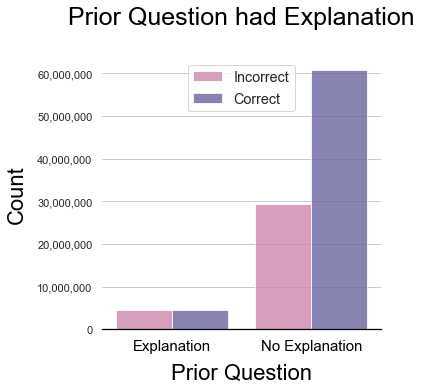

In [126]:
plt.figure(figsize = (5, 5))
ax = sns.countplot(data=df, x='prior_question_had_explanation', hue='answered_correctly', palette=['#d77ead', '#645ca7'], alpha=.8)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20', loc='upper center')
ax.axes.set_title("Prior Question had Explanation", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Prior Question",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='black', labelpad=10)
ax.set_xticklabels(['Explanation', 'No Explanation'], fontsize=15, color='black')
# ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/prior_q_explanation.png', bbox_inches='tight', transparent=True);

In [128]:
# # Average Time per Question
# plt.figure(figsize = (6, 6))
# ax = sns.barplot('answered_correctly', 'avg_time_per_question', estimator=np.mean, data=df,
#                  palette=['#d77ead', '#645ca7'], alpha=.8)
# ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='black')
# # legend_labels, _= ax.get_legend_handles_labels()
# # ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
# ax.axes.set_title("Average Time per Question", y= 1.1, fontsize=25, color='black')
# ax.set_xlabel("Answers",fontsize=22, color='black', labelpad=10)
# ax.set_ylabel("Time(milliseconds)",fontsize=22, color='black', labelpad=10)
# # ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
# # ax.set_yticklabels(['0', '5,000', '10,000', '15,000', '20,000', '25,000'], fontsize=15, color='black')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('black')
# plt.savefig('../../reports/figures/Average_Time_Per_Question.png', bbox_inches='tight', transparent=True);

#### Taking a subset of the data to work with

In [129]:
# Take a smaller subset of the data to work with (100,000 rows)
# Taking the first 100,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_small = pd.read_sql("""SELECT * 
FROM train
LIMIT 100000;""", conn)

conn.close()

In [130]:
def engineer_data(data):

    # read in questions and lectures tables from database
    DBNAME = "riiid_education"
    conn = psycopg2.connect(dbname=DBNAME)
    cursor = conn.cursor()
    questions = pd.read_sql("SELECT * FROM questions;", conn)
    lectures = pd.read_sql("SELECT * FROM lectures;", conn)
    conn.close()
    
    # Drop all rows with answered_correctly is blank (-1) since these are lectures, not questions
    data = data[data.content_type_id != 1]
    df = data.merge(questions, left_on='content_id', right_on='question', how='left')
    
    # Drop the columns we don't need
    # question is already there as content id
    # user_answer doesn't make sense to have - we can't know that in advance
    # There are only 2 unique content_type_ids and we dropped one type, no point having a column of zeros
    df.drop(['tags', 'question', 'user_answer', 'content_type_id'], axis=1, inplace=True)
    
    # Engineer Feature for how many questions this user has answered prior
    df["user_question_count"] = df.groupby("user_id").cumcount() + 1
    
    # Engineer Feature for average time per questions per user for prior questions
    cumsum = df.groupby("user_id")["prior_question_elapsed_time"].cumsum()
    count = df.groupby("user_id").cumcount() + 1
    df["avg_time_per_question"] = round(cumsum/count, 0)
    
    # Change string object type to bool on prior_question_had_explanation
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')
    
    return df

In [131]:
df = engineer_data(data_small)

In [132]:
# # Average Prior Question Elapsed Time ppt
# plt.figure(figsize = (6, 6))
# ax = sns.barplot('answered_correctly', 'prior_question_elapsed_time', estimator=np.mean, data=df, palette=['#d77ead', '#645ca7'])
# ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='white')
# # legend_labels, _= ax.get_legend_handles_labels()
# # ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
# ax.axes.set_title("Average Prior Question Elapsed Time", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Time (milliseconds)",fontsize=22, color='white', labelpad=10)
# # ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '5,000', '10,000', '15,000', '20,000', '25,000'], fontsize=15, color='white')
# # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# plt.savefig('../../reports/figures/prior_question_had_explanation_ppt.png', bbox_inches='tight', transparent=True);

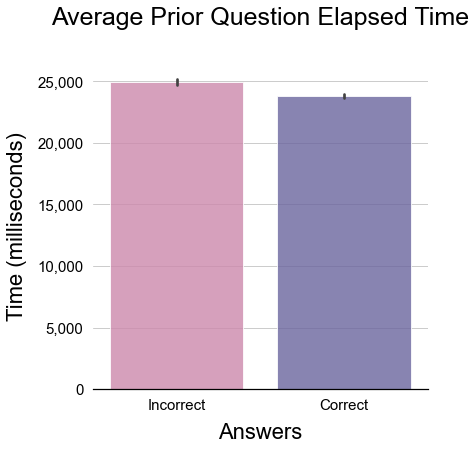

In [133]:
# Average Prior Question Elapsed Time
plt.figure(figsize = (6, 6))
ax = sns.barplot('answered_correctly', 'prior_question_elapsed_time', estimator=np.mean, data=df,
                 palette=['#d77ead', '#645ca7'], alpha=.8)
ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='black')
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Average Prior Question Elapsed Time", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Answers",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Time (milliseconds)",fontsize=22, color='black', labelpad=10)
# ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
ax.set_yticklabels(['0', '5,000', '10,000', '15,000', '20,000', '25,000'], fontsize=15, color='black')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
plt.savefig('../../reports/figures/prior_question_had_explanation.png', bbox_inches='tight', transparent=True);

In [134]:
# # Average Time per Question ppt
# plt.figure(figsize = (6, 6))
# ax = sns.barplot('answered_correctly', 'avg_time_per_question', estimator=np.mean, data=df, palette=['#d77ead', '#645ca7'])
# ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='white')
# # legend_labels, _= ax.get_legend_handles_labels()
# # ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
# ax.axes.set_title("Average Time per Question", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Time(milliseconds)",fontsize=22, color='white', labelpad=10)
# # ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '5,000', '10,000', '15,000', '20,000', '25,000'], fontsize=15, color='white')
# # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# plt.savefig('../../reports/figures/Average_Time_Per_Question_ppt.png', bbox_inches='tight', transparent=True);

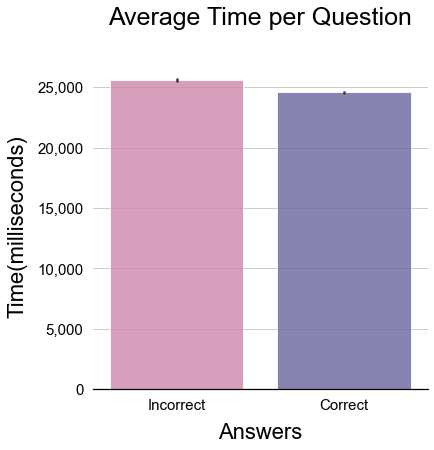

In [135]:
# Average Time per Question
plt.figure(figsize = (6, 6))
ax = sns.barplot('answered_correctly', 'avg_time_per_question', estimator=np.mean, data=df,
                 palette=['#d77ead', '#645ca7'], alpha=.8)
ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='black')
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Average Time per Question", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Answers",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Time(milliseconds)",fontsize=22, color='black', labelpad=10)
# ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
ax.set_yticklabels(['0', '5,000', '10,000', '15,000', '20,000', '25,000'], fontsize=15, color='black')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
plt.savefig('../../reports/figures/Average_Time_Per_Question.png', bbox_inches='tight', transparent=True);

In [136]:
# # Average Timestamp per User ppt
# plt.figure(figsize = (6, 6))
# ax = sns.barplot('answered_correctly', 'timestamp', estimator=np.mean, data=df, palette=['#d77ead', '#645ca7'])
# ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='white')
# # legend_labels, _= ax.get_legend_handles_labels()
# # ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
# ax.axes.set_title("Average TimeStamp per User", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Time(milliseconds)",fontsize=22, color='white', labelpad=10)
# # ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '1 billion', '1 billion', '2 billion', '3 billion', '4 billion'], fontsize=15, color='white')
# # ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# plt.savefig('../../reports/figures/average_timestamp_ppt.png', bbox_inches='tight', transparent=True);

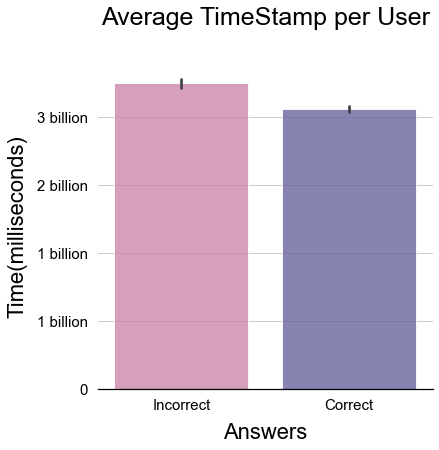

In [137]:
# Average Timestamp per User
plt.figure(figsize = (6, 6))
ax = sns.barplot('answered_correctly', 'timestamp', estimator=np.mean, data=df, palette=['#d77ead', '#645ca7'], alpha=.8)
ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='black')
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Average TimeStamp per User", y= 1.1, fontsize=25, color='black')
ax.set_xlabel("Answers",fontsize=22, color='black', labelpad=10)
ax.set_ylabel("Time(milliseconds)",fontsize=22, color='black', labelpad=10)
# ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
ax.set_yticklabels(['0', '1 billion', '1 billion', '2 billion', '3 billion', '4 billion'], fontsize=15, color='black')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('black')
plt.savefig('../../reports/figures/average_timestamp.png', bbox_inches='tight', transparent=True);

### Prepare data for modeling

In [138]:
# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [139]:
# Pipeline for preprocessing numeric features
# numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_features = ['timestamp', 'row_id', 'user_id', 'content_id', 'task_container_id',
                    'prior_question_elapsed_time', 'avg_time_per_question', 'bundle_id', 'user_question_count']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
# categorical_features = list(X.select_dtypes(include='object').columns)
categorical_features = ['part', 'prior_question_had_explanation', 'correct_answer']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value='None')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [140]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Modeling

#### First Simple Model

In [141]:
# Logistic Regression Model Fit
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

In [142]:
# Score on our training data
y_pred = fsm.predict(X_train_transformed)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.03      0.05     28221
           1       0.64      0.99      0.78     50091

    accuracy                           0.64     78312
   macro avg       0.59      0.51      0.41     78312
weighted avg       0.60      0.64      0.52     78312



In [143]:
# Score on our testing data
y_pred = fsm.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.03      0.05      7170
           1       0.64      0.99      0.77     12408

    accuracy                           0.64     19578
   macro avg       0.59      0.51      0.41     19578
weighted avg       0.60      0.64      0.51     19578



In [144]:
cross_val_score(fsm, X_test_transformed, y_test, cv=4)

array([0.63534219, 0.63554648, 0.62872906, 0.63935431])

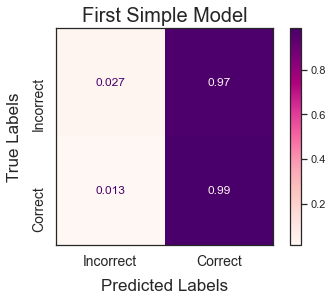

In [145]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(fsm, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.title('First Simple Model',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14)
plt.savefig('../../reports/figures/fsm_matrix.png', bbox_inches='tight', transparent=True);

We are severely underpredicting incorrectly answered. Our recall is a mere .12. This is due to class imbalance - there are much more correctly answered questions than incorrect. Let's resample the data the adress this issue

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [45]:
print("Before OverSampling, counts of label -1: {}".format(sum(y_train == -1))) 
print("Before OverSampling, counts of label 0: {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 1: {} \n".format(sum(y_train == 1))) 

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label -1: {}".format(sum(y_train_res == -1))) 
print("After OverSampling, counts of label 0".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label 1: {}".format(sum(y_train_res == 1)))

Before OverSampling, counts of label -1: 0
Before OverSampling, counts of label 0: 27756
Before OverSampling, counts of label 1: 50606 

After OverSampling, the shape of train_X: (101212, 22)
After OverSampling, the shape of train_y: (101212,) 

After OverSampling, counts of label -1: 0
After OverSampling, counts of label 0
After OverSampling, counts of label 1: 50606


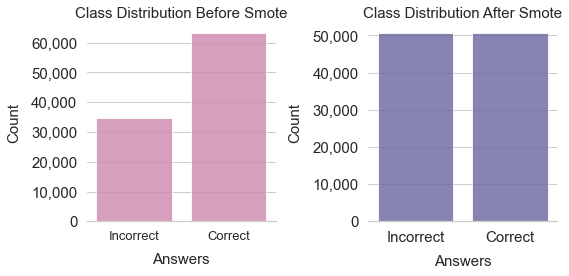

In [46]:
sns.set(context = 'notebook', style = 'whitegrid')

fig, axes = plt.subplots(1, 2, figsize = (8,4)) 
ax = sns.countplot(y, palette = ['#d77ead', '#d77ead'], ax=axes[0], alpha=.8)
ax.set_title("Class Distribution Before Smote",fontsize=15)
ax.set_xlabel("Answers",fontsize=15, labelpad=10)
ax.set_ylabel("Count",fontsize=15,  labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=13)
ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax2 = sns.countplot(y_train_res, palette = ['#645ca7', '#645ca7'], ax=axes[1], alpha=.8)
ax2.set_title("Class Distribution After Smote",fontsize=15)
ax2.set_xlabel("Answers",fontsize=15, labelpad=10)
ax2.set_ylabel("Count",fontsize=15,  labelpad=10)
ax2.set_xticklabels(['Incorrect', "Correct"], fontsize=15)
ax2.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

In [47]:
# # PPT Viz
# plt.figure(figsize = (5, 5))
# ax = sns.countplot(data=df, x='prior_question_had_explanation', hue='answered_correctly', palette=['#d77ead', '#645ca7'])
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20', loc='upper center')
# ax.axes.set_title("Prior Question had Explanation", y= 1.1, fontsize=25, color='white')
# ax.set_xlabel("Prior Question",fontsize=22, color='white', labelpad=10)
# ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
# ax.set_xticklabels(['Explanation', 'No Explanation'], fontsize=15, color='white')
# ax.set_yticklabels(['0', '10,000', '20,000', '30,000', '40,000', '50,000', '60,000'], fontsize=15, color='white')
# ax.grid(color='white', axis='y')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('white')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.savefig('../../reports/figures/prior_q_explanation_ppt.png', bbox_inches='tight', transparent=True);

#### Simple Linear Regression Model After Smote

In [48]:
# X_train_res, y_train_res, X_test_transformed, y_test
simple_lr = LogisticRegression()
with joblib.parallel_backend('dask'):
    simple_lr.fit(X_train_res, y_train_res)

In [49]:
# Score on our training data
y_pred = simple_lr.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56     50606
           1       0.56      0.54      0.55     50606

    accuracy                           0.56    101212
   macro avg       0.56      0.56      0.56    101212
weighted avg       0.56      0.56      0.56    101212



In [50]:
# Score on testing data
y_pred = simple_lr.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.58      0.48      6987
           1       0.70      0.54      0.61     12604

    accuracy                           0.55     19591
   macro avg       0.55      0.56      0.54     19591
weighted avg       0.60      0.55      0.56     19591



In [51]:
cross_val_score(simple_lr, X_test_transformed, y_test, cv=4)

array([0.64311964, 0.64434463, 0.6445488 , 0.64345518])

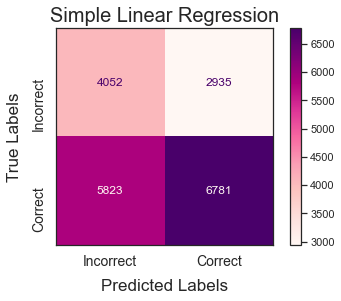

In [52]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(simple_lr, X_test_transformed, y_test, cmap='RdPu')
plt.title('Simple Linear Regression',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

In [53]:
# # Grid Search for best params for Logistic Regression Classifier
# params = {
#     'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
#     'solver':['liblinear', 'saga'],
#     'C': [.001,.1, 1, 10],
#     'verbose': [0, 1],
#     'max_iter': [.5, 1, 2],
#     'tol': [1, 10, 100]
# }
# lr_gs = GridSearchCV(LogisticRegression(random_state=42), params, cv=3)
# with joblib.parallel_backend('dask'):
#     lr_gs.fit(X_train_res, y_train_res)

# print("Best Params", lr_gs.best_params_)
# print("Best Score", lr_gs.best_score_)

# # Best Params {'C': 1, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1, 'verbose': 0}
# # Best Score 0.5575444544102709

In [54]:
# Plug in best params and run model
lr_best = LogisticRegression(random_state=42, penalty= 'l2', solver= 'liblinear', C=1, verbose=0, max_iter=1, tol=1)
lr_best.fit(X_train_res, y_train_res)

LogisticRegression(C=1, max_iter=1, random_state=42, solver='liblinear', tol=1)

In [55]:
# Score on our training data
y_pred = lr_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56     50606
           1       0.56      0.54      0.55     50606

    accuracy                           0.56    101212
   macro avg       0.56      0.56      0.56    101212
weighted avg       0.56      0.56      0.56    101212



In [56]:
# Score on testing data
y_pred = lr_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.58      0.48      6987
           1       0.70      0.54      0.61     12604

    accuracy                           0.55     19591
   macro avg       0.55      0.56      0.54     19591
weighted avg       0.59      0.55      0.56     19591



In [57]:
cross_val_score(lr_best, X_test_transformed, y_test, cv=4)

array([0.64352797, 0.64352797, 0.64291548, 0.64304676])

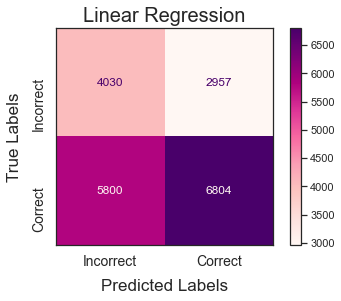

In [58]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(lr_best, X_test_transformed, y_test, cmap='RdPu')
plt.title('Linear Regression',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### K Nearest Neighbors

In [59]:
# # Grid Search for best params for KNN Classifier *Do this overnight, takes forever*
# params = {
#     'n_neighbors': [3, 5],
#     'weights': ['uniform', 'distance'],
#     'p' : [1,2]
# }

# knn_gs = GridSearchCV(KNeighborsClassifier(), params)
# with joblib.parallel_backend('dask'):
#     knn_gs.fit(X_train_res, y_train_res)

# print("Best Params", knn_gs.best_params_)

In [60]:
# Plug in best params and run model
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_res, y_train_res)

KNeighborsClassifier()

In [61]:
# Score on our training data
y_pred = knn_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80     50606
           1       0.83      0.72      0.77     50606

    accuracy                           0.78    101212
   macro avg       0.79      0.78      0.78    101212
weighted avg       0.79      0.78      0.78    101212



In [62]:
# Score on testing data
y_pred = knn_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.54      0.47      6987
           1       0.69      0.58      0.63     12604

    accuracy                           0.56     19591
   macro avg       0.55      0.56      0.55     19591
weighted avg       0.59      0.56      0.57     19591



In [63]:
cross_val_score(knn_best, X_test_transformed, y_test, cv=4)

array([0.62209065, 0.60881993, 0.60943242, 0.60976108])

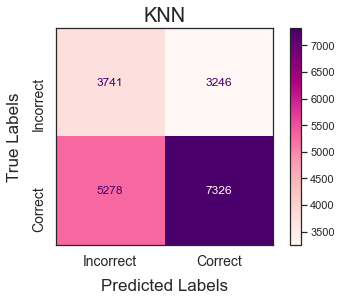

In [64]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(knn_best, X_test_transformed, y_test, cmap='RdPu')
plt.title('KNN',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Random Forest

In [65]:
# # Grid Search for best params for Random Forest Classifier
# params = {
#     'max_depth': [10, 16, 20],
#     'n_estimators': [700, 800]
# }

# rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), params)
# with joblib.parallel_backend('dask'):
#     rf_gs.fit(X_train_res, y_train_res)

# print("Best Params", rf_gs.best_params_)

In [66]:
# Plug in best params and run model
rf_best = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    rf_best.fit(X_train_res, y_train_res)

In [67]:
# Score on our training data
y_pred = rf_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     50606
           1       0.84      0.80      0.82     50606

    accuracy                           0.82    101212
   macro avg       0.82      0.82      0.82    101212
weighted avg       0.82      0.82      0.82    101212



In [68]:
# Score on testing data
y_pred = rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.56      0.51      6987
           1       0.73      0.65      0.69     12604

    accuracy                           0.62     19591
   macro avg       0.60      0.60      0.60     19591
weighted avg       0.63      0.62      0.62     19591



In [69]:
cross_val_score(rf_best, X_test_transformed, y_test, cv=4)

array([0.66721111, 0.65536954, 0.65373622, 0.66836839])

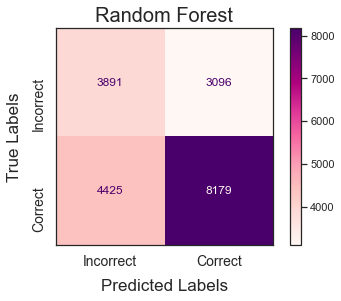

In [70]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(rf_best, X_test_transformed, y_test, cmap='RdPu', values_format = '.0f')
plt.title('Random Forest',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Support Vector Machines

This is a slow one not great performing

In [71]:
# # Instantiate SVC
# svc = SVC(cache_size=500, random_state=42)
# with joblib.parallel_backend('dask'):
#     svc.fit(X_train_res, y_train_res)

In [72]:
# # Score on our training data
# y_pred = svc.predict(X_train_res)
# print(classification_report(y_train_res, y_pred))

In [73]:
# # Score on testing data
# y_pred = svc.predict(X_test_transformed)
# print(classification_report(y_test, y_pred))

In [74]:
# # Confusion matrix
# plot_confusion_matrix(svc, X_test_transformed, y_test)
# plt.title('SVC');

#### AdaBoost

In [75]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_res, y_train_res)

AdaBoostClassifier(random_state=42)

In [76]:
# Score on our training data
y_pred = adaboost.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60     50606
           1       0.60      0.60      0.60     50606

    accuracy                           0.60    101212
   macro avg       0.60      0.60      0.60    101212
weighted avg       0.60      0.60      0.60    101212



In [77]:
# Score on testing data
y_pred = adaboost.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.57      0.50      6987
           1       0.71      0.60      0.65     12604

    accuracy                           0.59     19591
   macro avg       0.58      0.58      0.57     19591
weighted avg       0.62      0.59      0.59     19591



In [78]:
cross_val_score(adaboost, X_test_transformed, y_test, cv=4)

array([0.65577787, 0.65006125, 0.65251123, 0.66183378])

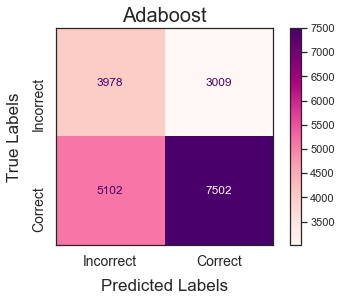

In [79]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(adaboost, X_test_transformed, y_test, cmap='RdPu')
plt.title('Adaboost',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Extreme Gradient Boosting

In [80]:
# Instantiate XGBClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
# XGB Optomized for distributed computing. Parallel training.
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(random_state=42)

In [81]:
# Score on our training data
y_pred = xgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64     50606
           1       0.64      0.64      0.64     50606

    accuracy                           0.64    101212
   macro avg       0.64      0.64      0.64    101212
weighted avg       0.64      0.64      0.64    101212



In [82]:
# Score on testing data
y_pred = xgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.55      0.50      6987
           1       0.72      0.63      0.67     12604

    accuracy                           0.60     19591
   macro avg       0.59      0.59      0.59     19591
weighted avg       0.62      0.60      0.61     19591



In [83]:
cross_val_score(xgb, X_test_transformed, y_test, cv=4)

array([0.65904451, 0.65659453, 0.65679869, 0.66183378])

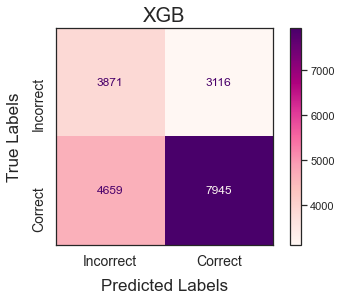

In [84]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(xgb, X_test_transformed, y_test, cmap='RdPu')
plt.title('XGB',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);
plt.savefig('../../reports/figures/xgb_matrix.png', bbox_inches='tight', transparent=True);

#### Light Gradient Boosting

In [85]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
lgb = LGBMClassifier(seed=42)
lgb.fit(X_train_res, y_train_res)

LGBMClassifier(seed=42)

In [86]:
# Score on our training data
y_pred = lgb.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69     50606
           1       0.68      0.76      0.72     50606

    accuracy                           0.70    101212
   macro avg       0.71      0.70      0.70    101212
weighted avg       0.71      0.70      0.70    101212



In [87]:
# Score on testing data
y_pred = lgb.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.46      0.47      6987
           1       0.71      0.74      0.72     12604

    accuracy                           0.64     19591
   macro avg       0.60      0.60      0.60     19591
weighted avg       0.63      0.64      0.63     19591



In [88]:
cross_val_score(lgb, X_test_transformed, y_test, cv=4)

array([0.66659861, 0.65475704, 0.65373622, 0.6657137 ])

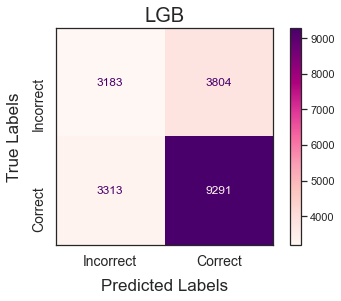

In [89]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(lgb, X_test_transformed, y_test, cmap='RdPu')
plt.title('LGB',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14);

#### Training our best model(Random Forest) with a bigger subset of the Data

In [148]:
# Take a smaller subset of the data to work with (100,000 rows)
# Taking the first 1,000,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_med = pd.read_sql("""SELECT * 
FROM train
LIMIT 1000000;""", conn)

conn.close()

# Use our function which does our data engineering
df = engineer_data(data_med)

# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel())

In [149]:
# Plug in best params and run model
rf_best = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    rf_best.fit(X_train_res, y_train_res)

In [150]:
# Score on our training data
y_pred = rf_best.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69    513551
           1       0.69      0.67      0.68    513551

    accuracy                           0.68   1027102
   macro avg       0.68      0.68      0.68   1027102
weighted avg       0.68      0.68      0.68   1027102



In [151]:
# Score on testing data
y_pred = rf_best.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.55      0.49     67384
           1       0.73      0.63      0.67    128686

    accuracy                           0.60    196070
   macro avg       0.58      0.59      0.58    196070
weighted avg       0.63      0.60      0.61    196070



In [94]:
# Cross Validation Scores
cross_val_score(rf_best, X_test_transformed, y_test, cv=4)

array([0.67361224, 0.67102041, 0.67342857, 0.67289128])

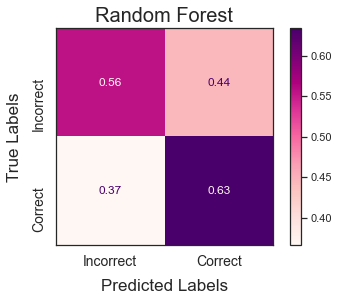

In [97]:
# Confusion matrix
sns.set(context = 'notebook', style = 'white')
plot_confusion_matrix(rf_best, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.title('Random Forest',fontsize=20)
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10)
plt.ylabel("True Labels",fontsize=17,  labelpad=10)
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14)
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14)
plt.savefig('../../reports/figures/rf_matrix.png', bbox_inches='tight', transparent=True);

#### To use our model on a new dataset, import the test set as a pandas dataframe called data and run the following

In [ ]:
# # Use our function which does our data engineering
# df = engineer_data(data)

# # Use preprocessing pipeline which is fit on our train data to transform the test data
# X_test = preprocessor.transform(df)

# # Make Predictions
# y_pred = rf_best.predict(X_test)

# Conclusion
We can use these predictions to improve and prove the success of AI tutors. Knowing how the student is likely to perform in the future and give better insight for the AI to individualize education and personalize the learning experience for each student to achieve the best results.

AI tutors could be a much needed change in our education system to provide equal opportunity and improve the success of students around the globe.